## Finding the coordinate of aorta using Unet

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import pydicom
from tensorflow import keras
from skimage import io
from skimage.filters import sobel
from natsort import natsorted

root_folder = "M2S"
output_folder = "Unet_output"
os.makedirs(output_folder, exist_ok=True)
model_path = 'aorta_unet_200epoch_JDS_RTE_TAJ_out_nonPreProcessed_512.h5'
threshold = 600  # Number of segmented pixels threshold

def count_segmented_pixels(image, threshold=0.5):
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_mask = pred[0] > threshold
    return np.count_nonzero(pred_mask), pred_mask

def convert_to_8bit(image):
    # Define desired minimum and maximum values
    new_min = 10  # Adjust these values as needed (0-255)
    new_max = 245  # Adjust these values as needed (0-255)
    # Calculate scaling factor
    scale_factor = (new_max - new_min) / (np.max(image) - np.min(image))
    # Apply linear stretching
    stretched_image = (image - np.min(image)) * scale_factor + new_min
    # Convert to 8-bit format
    image_8bit = stretched_image.astype(np.uint8)
    return image_8bit

def find_center_of_mask(mask):
    """Find the center (x, y) of the segmented region in the mask."""
    y_coords, x_coords = np.where(mask > 0)
    if len(x_coords) == 0 or len(y_coords) == 0:
        return None, None
    center_x = int(np.mean(x_coords))
    center_y = int(np.mean(y_coords))
    return center_x, center_y

def analyze_folders():
    results = []
    for root, dirs, files in os.walk(root_folder):
        for folder in dirs:
            if folder.endswith("101"):
                src_folder_path = os.path.join(root, folder)
                dicom_files = natsorted([f for f in os.listdir(src_folder_path) if f.endswith(".dcm")])
                
                # Process each file in the folder until a slice with over 500 segmented pixels is found
                for idx, file in enumerate(dicom_files):
                    dicom_path = os.path.join(src_folder_path, file)
                    with pydicom.dcmread(dicom_path) as dcm:
                        np_page = dcm.pixel_array.astype(np.float32)
                        np_page_8bit = convert_to_8bit(np_page)
                        np_page_8bit = np.repeat(np_page_8bit[:, :, np.newaxis], 3, axis=2)
                        segmented_pixels, pred_msk = count_segmented_pixels(np_page_8bit)
                        print(f"DICOM: {dicom_path}, Segmented Pixels: {segmented_pixels}")

                        # If segmented pixels exceed the threshold, find the center of the mask
                        if segmented_pixels > threshold:
                            center_x, center_y = find_center_of_mask(pred_msk.squeeze())
                            print("hhh", pred_msk.shape, center_x, center_y )
                            
                            if center_x is not None and center_y is not None:
                                # Save the result for the current folder with slice number
                                results.append((folder, idx, center_x, center_y))
                                break  # Move to the next folder after recording the first slice

    return results

# Load the model
model = keras.models.load_model(model_path, compile=False)

# Analyze the folders and save the results to a text file
results = analyze_folders()

output_file_path = os.path.join(output_folder, "slice_centers.txt")
with open(output_file_path, "w") as file:
    for result in results:
        folder_name, slice_idx, center_x, center_y = result
        file.write(f"{folder_name}, Slice {slice_idx}: [x, y] = [{center_x}, {center_y}]\n")

print(f"Results saved to {output_file_path}")


## Track aorta through aneurysm with SAM2 using the coordinate from Unet

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import re

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True


print(f"Using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

# Model setup
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

# Helper functions

def extract_info(line):
    match = re.match(r"(\d+-\d+-\d+), Slice (\d+): \[x, y\] = \[(\d+), (\d+)\]", line)
    if match:
        return match.group(1), int(match.group(2)), int(match.group(3)), int(match.group(4))
    else:
        return None, None, None

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0


    # Function to convert mask to a visualization
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def process_directory(video_dir, pt, slice_num, output_dir):
    
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)

    ann_frame_idx = slice_num
    ann_obj_id = 1
    points = np.array([pt], dtype=np.float32)

    labels = np.array([1], np.int32)
    
    # observing that sometimes Sam2 fails to capture the Region on interest in the first attempt, we repeat that for 3 times
    segmented_pixels_limit = 4000
    for attempt in range(5):
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

        # Calculate the number of segmented pixels
        segmented_pixels = np.sum(out_mask_logits[0].cpu().numpy() > 0.0)
        
        # Check if segmented pixels exceed 3000
        if segmented_pixels > segmented_pixels_limit: #since 
            print(f"Segmented pixels ({segmented_pixels}) exceed 3000, retrying {attempt+1}/3...")
            continue  # Retry up to 3 times if the condition is met
        else:
            break  # If segmented pixels are below 3000, break the loop 
    
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])



    # Run propagation throughout the video and collect the results in a dict
    video_segments = {}  # contains per-frame segmentation results
    segmented_pixels_per_slice = []  # Store the number of segmented pixels per slice

    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

        # Count the number of segmented pixels (non-zero pixels) for this frame
        segmented_pixels_count = 0
        for out_mask in video_segments[out_frame_idx].values():
            segmented_pixels_count += np.sum(out_mask)  # count non-zero pixels
        segmented_pixels_per_slice.append(segmented_pixels_count)

    # Tag slices for abnormality start/end
    abnormalities = []  # List to store all abnormality (start, end) pairs
    current_abnormality = None  # Store the current abnormality being detected


    #### expert rule to find the start and end of the aneurysm
    # Window size for comparison
    window_size = 4

    for idx in range(window_size, len(segmented_pixels_per_slice)):
        # Get the average segmented pixel count over the previous window of slices
        prev_avg = np.mean(segmented_pixels_per_slice[idx-window_size:idx])

        # Check for a 20% rise
        if (segmented_pixels_per_slice[idx] > prev_avg * 1.2):
            if all(segmented_pixels_per_slice[i] > prev_avg * 1.2 for i in range(idx, idx+window_size)):
                if current_abnormality is None:  # Detect abnormality start
                    current_abnormality = {"start": idx}

        # Check for a 20% drop, ensuring an abnormality start exists and end comes after start
        if current_abnormality is not None and "start" in current_abnormality:
            if (segmented_pixels_per_slice[idx] < prev_avg * 0.8):
                if all(segmented_pixels_per_slice[i] < prev_avg * 0.8 for i in range(idx, idx+window_size)):
                    current_abnormality["end"] = idx
                    abnormalities.append(current_abnormality)  # Record the abnormality
                    current_abnormality = None  # Reset after tagging the end

    # Find the widest abnormality (longest span)
    widest_abnormality = None
    widest_span = 0

    for abnormality in abnormalities:
        if "start" in abnormality and "end" in abnormality:
            span = abnormality["end"] - abnormality["start"]
            if span > widest_span:
                widest_span = span
                widest_abnormality = abnormality

    # Calculate the sum of segmented pixels for the widest abnormality
    if widest_abnormality:
        start = widest_abnormality["start"]
        end = widest_abnormality["end"]
        sum_segmented_pixels = sum(segmented_pixels_per_slice[start:end+1])
    else:
        sum_segmented_pixels = 0

    # Render and save the segmentation results and the plot
    vis_frame_stride = 1
    plt.close("all")

    for out_frame_idx in range(slice_num, len(frame_names), vis_frame_stride):
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

        # Remove titles and axes
        plt.axis('off')
        
        # Save the figure without borders and titles
        output_path = os.path.join(output_dir, f"frame_{out_frame_idx}.png")
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

    # Save the segmented pixel counts and abnormality tags in a text file
    pixel_count_file_path = os.path.join(output_dir, 'segmented_pixels_per_slice.txt')
    with open(pixel_count_file_path, 'w') as f:
        for idx, count in enumerate(segmented_pixels_per_slice):
            f.write(f"Frame {idx+slice_num}: {count} segmented pixels\n")

    # Plot the number of segmented pixels per slice
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(segmented_pixels_per_slice)), segmented_pixels_per_slice)
    plt.xlabel('Frame Index')
    plt.ylabel('Segmented Pixels Count')
    plt.title('Segmented Pixels per Slice')
    plt.grid(True)

    # Save the plot showing the number of segmented pixels per slice
    plot_output_path = os.path.join(output_dir, 'segmented_pixels_per_slice.png')
    plt.savefig(plot_output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    return widest_abnormality, sum_segmented_pixels

def main():

    root_dir = "/home/alireza/Desktop/aorta/aneurysm_jpg"
    output_dir = "/home/alireza/Desktop/aorta/sam2_pred"
    slice_centers_file = "/home/alireza/Desktop/aorta/aneurysm_jpg/aorta_loc_full.txt"
    results = {}
       
    sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"

    # Extract information from slice_centers.txt
    slice_numbers = []
    x_coords = []
    y_coords = []
    id_all = []
    
    with open(slice_centers_file, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        id, slice_number, x, y = extract_info(line)
        if slice_number is not None:
            slice_numbers.append(slice_number)
            x_coords.append(x)
            y_coords.append(y)
            id_all.append(id)
    # print(x_coords, y_coords, slice_numbers)


    for i, id in enumerate(id_all):           
        for subdir in os.listdir(root_dir): 
            if subdir==id:
                subdir_path = os.path.join(root_dir, subdir)

                print(subdir_path, x_coords[i], y_coords[i], slice_numbers[i])

                output_dir_i = os.path.join(output_dir, f"{subdir}")
                
                if not os.path.exists(output_dir_i):
                    os.makedirs(output_dir_i, exist_ok=True)
                    os.makedirs(output_dir_i, exist_ok=True)
                    print(f"Processing directory: {subdir_path}")
                    widest_abnormality, sum_segmented_pixels = process_directory(subdir_path, [x_coords[i], y_coords[i]], slice_numbers[i], output_dir_i)
                    results[subdir] = {"widest_abnormality": widest_abnormality, "sum_segmented_pixels": sum_segmented_pixels}

                    summary_file_path = os.path.join(output_dir, "analysis_summary.txt")
                    with open(summary_file_path, "a") as f:
                        f.write(f"Directory: {subdir}\n")
                        if widest_abnormality:
                            f.write(f"Widest Abnormality: Frames {widest_abnormality['start'] + slice_numbers[i]} to {widest_abnormality['end'] +  slice_numbers[i]}\n")
                            f.write(f"Sum of segmented pixels: {sum_segmented_pixels}\n")
                        else:
                            f.write("No abnormalities detected.\n")
                        f.write("\n")

if __name__ == "__main__":
    main()

Using device: cuda
/home/alireza/Desktop/aorta/aneurysm_jpg/90605-136548-19700101 302 305 41
/home/alireza/Desktop/aorta/aneurysm_jpg/93602-141559-19700101 294 311 0
/home/alireza/Desktop/aorta/aneurysm_jpg/89993-135436-19700101 282 328 0
/home/alireza/Desktop/aorta/aneurysm_jpg/91427-137947-19700101 283 290 0
/home/alireza/Desktop/aorta/aneurysm_jpg/88841-133345-19700101 253 333 2
/home/alireza/Desktop/aorta/aneurysm_jpg/86951-130035-19700101 295 321 0
/home/alireza/Desktop/aorta/aneurysm_jpg/88327-132448-19700101 296 313 31
/home/alireza/Desktop/aorta/aneurysm_jpg/92852-140285-19700101 267 307 0
/home/alireza/Desktop/aorta/aneurysm_jpg/92704-140075-19700101 269 296 46
/home/alireza/Desktop/aorta/aneurysm_jpg/87563-130971-19700101 293 323 0
/home/alireza/Desktop/aorta/aneurysm_jpg/91538-138130-19700101 240 294 23
Processing directory: /home/alireza/Desktop/aorta/aneurysm_jpg/91538-138130-19700101


frame loading (JPEG): 100%|██████████| 151/151 [00:03<00:00, 47.44it/s]
/home/alireza/Desktop/aorta/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/alireza/Desktop/aorta/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 128/128 [00:09<00:00, 13.24it/s]


/home/alireza/Desktop/aorta/aneurysm_jpg/90771-136807-19700101 257 318 0
/home/alireza/Desktop/aorta/aneurysm_jpg/92573-139860-19700101 295 287 0
/home/alireza/Desktop/aorta/aneurysm_jpg/91493-138048-19700101 308 309 0
/home/alireza/Desktop/aorta/aneurysm_jpg/86953-130037-19700101 285 290 41
/home/alireza/Desktop/aorta/aneurysm_jpg/87408-130700-19700101 284 334 0
/home/alireza/Desktop/aorta/aneurysm_jpg/87013-130127-19700101 298 343 0
/home/alireza/Desktop/aorta/aneurysm_jpg/94155-142525-19700101 277 325 0
/home/alireza/Desktop/aorta/aneurysm_jpg/88941-133540-19700101 286 320 0
/home/alireza/Desktop/aorta/aneurysm_jpg/90465-136273-19700101 315 311 0
/home/alireza/Desktop/aorta/aneurysm_jpg/87916-131581-19700101 309 360 0
/home/alireza/Desktop/aorta/aneurysm_jpg/88358-132894-19700101 301 317 0
/home/alireza/Desktop/aorta/aneurysm_jpg/86816-129827-19700101 276 316 34
/home/alireza/Desktop/aorta/aneurysm_jpg/87770-131330-19700101 287 340 0
/home/alireza/Desktop/aorta/aneurysm_jpg/89221-13

## Training LST on the output of the SAM2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


class AneurysmANNLSTM(nn.Module):
    def __init__(self, input_size=200, lstm_hidden_size=600, hidden_size=600, output_size=200):
        super(AneurysmANNLSTM, self).__init__()

        # Input LSTM (Bidirectional)
        self.lstm_in = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, num_layers=2, 
                               batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_hidden_size * 2, hidden_size)  # Bi-directional LSTM -> *2 hidden size
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, int(hidden_size / 2))
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(int(hidden_size / 2), int(hidden_size / 4))
        self.relu4 = nn.ReLU()

        # Output LSTM (Bidirectional)
        self.lstm_out = nn.LSTM(input_size=int(hidden_size / 4), hidden_size=lstm_hidden_size, num_layers=2, 
                                batch_first=True, bidirectional=True)

        # Final fully connected layer for output
        self.fc5 = nn.Linear(lstm_hidden_size * 2, output_size)  # Bi-directional -> *2 hidden size
        
        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Add input size dimension [batch_size, sequence_length] -> [batch_size, sequence_length, 1]
        x = x.unsqueeze(-1)
        
        # Pass through input LSTM
        x, _ = self.lstm_in(x)  # x shape: [batch_size, sequence_length, lstm_hidden_size * 2]
        
        # Fully connected layers
        x = self.fc1(x)  # x shape: [batch_size, sequence_length, hidden_size]
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)

        # Pass through output LSTM
        x, _ = self.lstm_out(x)  # x shape: [batch_size, sequence_length, lstm_hidden_size * 2]
        
        # Take only the last time step's output for each sequence
        x = x[:, -1, :]  # x shape: [batch_size, lstm_hidden_size * 2]

        # Final fully connected layer to produce the output
        x = self.fc5(x)  # x shape: [batch_size, output_size]
        
        # Apply sigmoid activation
        x = self.sigmoid(x)  # Output between 0 and 1
        
        return x

# Initialize the model
model = AneurysmANNLSTM()

# Loss function (Binary Cross-Entropy since it's a binary classification problem)
criterion = nn.BCELoss()

# Optimizer (Adam optimizer for adaptive learning rates)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.float(), labels.float()  # Ensure the data is in float format
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if (i + 1) % 2 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / (i + 1):.4f}")

                running_loss = 0.0


Epoch 1/1000, Train Loss: 0.6916, Validation Loss: 0.6874
Validation loss decreased to 0.6874. Saving the model.
Epoch 2/1000, Train Loss: 0.6862, Validation Loss: 0.6795
Validation loss decreased to 0.6795. Saving the model.
Epoch 3/1000, Train Loss: 0.6762, Validation Loss: 0.6628
Validation loss decreased to 0.6628. Saving the model.
Epoch 4/1000, Train Loss: 0.6546, Validation Loss: 0.6098
Validation loss decreased to 0.6098. Saving the model.
Epoch 5/1000, Train Loss: 0.5777, Validation Loss: 0.4962
Validation loss decreased to 0.4962. Saving the model.
Epoch 6/1000, Train Loss: 0.4625, Validation Loss: 0.4340
Validation loss decreased to 0.4340. Saving the model.
Epoch 7/1000, Train Loss: 0.4069, Validation Loss: 0.4326
Validation loss decreased to 0.4326. Saving the model.
Epoch 8/1000, Train Loss: 0.4424, Validation Loss: 0.4222
Validation loss decreased to 0.4222. Saving the model.
Epoch 9/1000, Train Loss: 0.3981, Validation Loss: 0.4083
Validation loss decreased to 0.4083. S

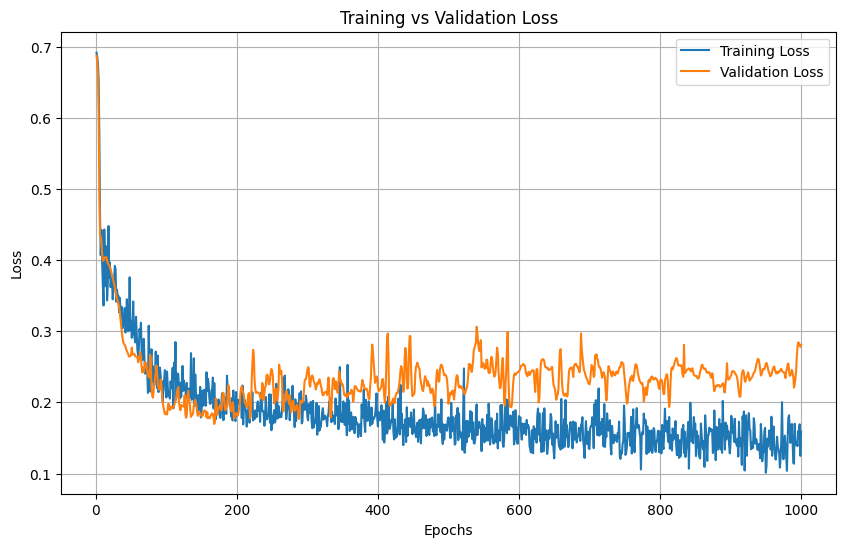

NameError: name 'evaluate_model' is not defined

In [137]:
import matplotlib.pyplot as plt
import torch

# Function to train the model and record the loss
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_save_path):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.float(), labels.float()
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate the training loss
            
        # Average training loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loop (evaluating the model on the validation set)
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in val_loader:
                inputs, labels = inputs.float(), labels.float()
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
        
        # Average validation loss for this epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
                # Save the model if the validation loss decreases
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Validation loss decreased to {best_val_loss:.4f}. Saving the model.")
            # torch.save(model.state_dict(), model_save_path)  # Save the best model

    
    return train_losses, val_losses

# Function to plot the training and validation loss
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Training the model
num_epochs = 1000
model_save_path = '/home/alireza/Desktop/aorta/sam2_pred/LSTM_locationDetect.pth'
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, model_save_path)

# Plot the training and validation loss
plot_loss(train_losses, val_losses)


In [139]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.float(), labels.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss:.4f}")

# Example: Evaluating the model
evaluate_model(model, test_loader)

Average test loss: 0.2809


## Testing LSTM performance for boundary detection

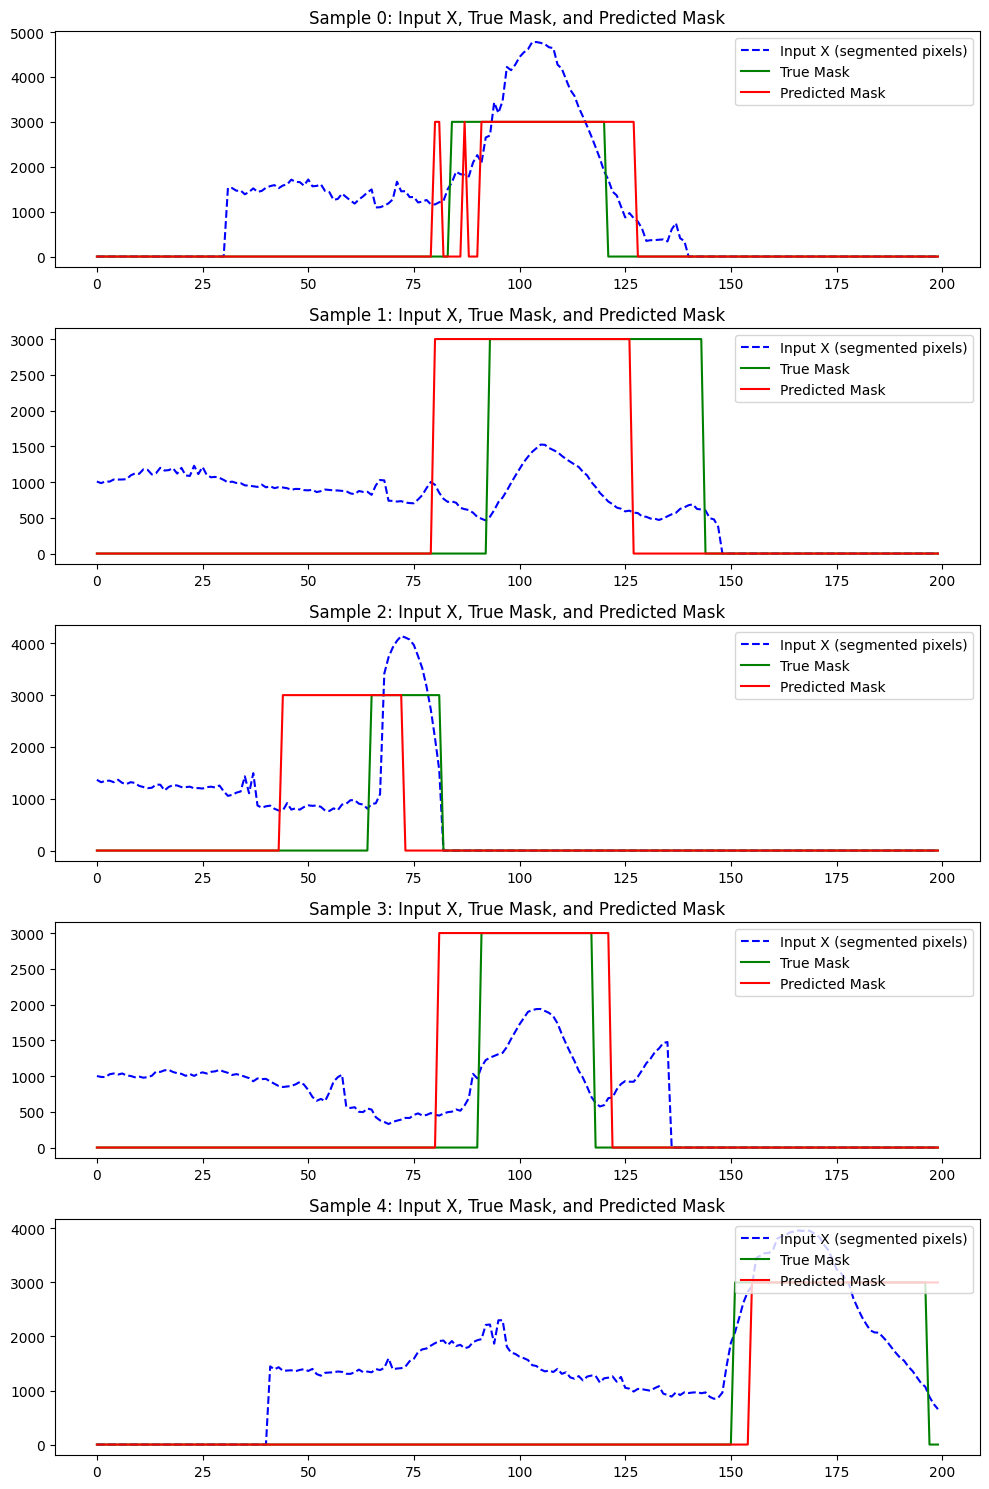

In [142]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_true = []
    all_pred = []
    all_X = []  # Store the input X values for plotting
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.float(), labels.float()
            
            # Forward pass to get outputs
            outputs = model(inputs)
            
            # Store inputs (X), true, and predicted labels for plotting
            all_X.append(inputs.cpu().numpy())
            all_true.append(labels.cpu().numpy())
            all_pred.append(outputs.cpu().numpy())
    
    # Concatenate the results for all batches
    all_X = np.concatenate(all_X, axis=0)
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Plot input X values, predicted vs. true values
    plot_predictions_vs_true(all_X, all_true, all_pred)

def plot_predictions_vs_true(X_values, true_values, pred_values, num_samples=5):
    plt.figure(figsize=(10, num_samples * 3))  # Adjust figure size for better visibility
    
    for i in range(num_samples):
        # Get the input X, true, and predicted masks for the sample
        X = X_values[i]
        true_mask = true_values[i]
        pred_mask = pred_values[i]>0.3 # Apply threshold to predictions
        
        # Create a single plot with three overlaid lines
        plt.subplot(num_samples, 1, i + 1)  # One subplot per sample
        plt.plot(X, label='Input X (segmented pixels)', color='blue', linestyle='--')
        plt.plot(true_mask*3000, label='True Mask', color='green')
        plt.plot(pred_mask*3000, label='Predicted Mask', color='red')
        
        # Add legend and title for each subplot
        plt.title(f'Sample {i}: Input X, True Mask, and Predicted Mask')
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example: Evaluating and plotting predictions for the test cases
evaluate_and_plot(model, test_loader)


## Unet + Sam2 + LSTM in 5-fold cross validation

In [196]:
#Unet + Sam2 + LSTM in cross validation
import os
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

class AneurysmDataset(Dataset):
    def __init__(self, file_paths, labels, input_size=200, augment=True):
        self.file_paths = file_paths
        self.labels = labels
        self.input_size = input_size
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        segmented_pixels = self._load_segmented_pixels(file_path)
        patient_id = os.path.basename(os.path.dirname(file_path))
        start, end = self.labels.get(patient_id, (0, 0))  # Get labels for the patient ID
        
        # Ensure the input has a consistent size (200 frames)
        segmented_pixels = self._pad_or_truncate(segmented_pixels)
        
        # Apply augmentations if enabled
        if self.augment:
            segmented_pixels, start, end = self._augment(segmented_pixels, start, end)
        
        # Create binary mask based on shifted start and end
        mask = np.zeros(self.input_size, dtype=np.int32)
        # if start < self.input_size:
        mask[start:min(end, self.input_size)] = 1
        
        return torch.tensor(segmented_pixels, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32), patient_id
    
    def _augment(self, data, start, end):
        # Random shift
        if random.random() > 0.5:
            data, start, end = self._shift_signal_and_labels(data, start, end)

        # Random scaling
        if random.random() > 0.5:
            data = self._scale_signal(data)

        return data, start, end
    
    def _shift_signal_and_labels(self, data, start, end, max_shift=90):
        """ Shift both the signal and the labels (start and end) left or right by a random number of frames """
        shift = random.randint(-max_shift//2, max_shift)  # Random shift between -max_shift and +max_shift
        
        # Shift the data
        if shift > 0:
            data = [0] * shift + data[:-shift]  # Shift right
        elif shift < 0:
            data = data[-shift:] + [0] * (-shift)  # Shift left
        
        # Adjust the start and end positions by the shift amount
        start = max(0, start + shift)
        end = max(0, end + shift)
        
        return data, start, end
    
    def _scale_signal(self, data, scale_range=(0.5, 1.5)):
        """ Scale the signal up or down by a random factor """
        scale_factor = random.uniform(*scale_range)  # Random scale factor between scale_range
        return [int(pixel * scale_factor) for pixel in data]
    
    def _load_segmented_pixels(self, file_path):
        segmented_pixels = {}
        with open(file_path, 'r') as f:
            for line in f:
                frame_info = line.split(':')[0].strip()
                pixel_value = int(line.split(':')[1].split('segmented pixels')[0].strip())
                frame_idx = int(frame_info.split(' ')[1])
                segmented_pixels[frame_idx] = pixel_value
        
        # Create a list of pixel values for each frame
        max_frame_idx = max(segmented_pixels.keys(), default=-1)
        pixel_values = [segmented_pixels.get(i, 0) for i in range(max_frame_idx + 1)]
        return pixel_values

    def _pad_or_truncate(self, data):
        if len(data) < self.input_size:
            data = data + [0] * (self.input_size - len(data))
        elif len(data) > self.input_size:
            data = data[:self.input_size]
        return data


# Manual k-fold cross-validation function
def manual_k_fold_split(file_paths, k):
    indices = list(range(len(file_paths)))
    random.shuffle(indices)
    
    # Split into k approximately equal folds
    fold_sizes = [len(file_paths) // k] * k
    for i in range(len(file_paths) % k):
        fold_sizes[i] += 1
    
    folds = []
    current_index = 0
    for fold_size in fold_sizes:
        val_indices = indices[current_index:current_index + fold_size]
        train_indices = indices[:current_index] + indices[current_index + fold_size:]
        folds.append((train_indices, val_indices))
        current_index += fold_size
    
    return folds


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.float(), labels.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.float(), labels.float()
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses


def get_start_end_indices(mask):
    """Extracts the start and end indices of continuous `1s` in a mask."""
    ones_indices = torch.nonzero(mask, as_tuple=True)[0]  # Get indices of 1s
    if len(ones_indices) > 0:
        start = int(ones_indices[0].item())
        end = int(ones_indices[-1].item()) + 1  # End is inclusive, so we add 1
    else:
        start, end = -1, -1  # If no 1s, return -1 for both
    return start, end

def evaluate_model_on_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    results = []
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels, patient_ids in test_loader:  # Expect patient_ids now
            inputs, labels = inputs.float(), labels.float()
            outputs = model(inputs)
            predicted_labels = (outputs > 0.3).float()  # Convert sigmoid output to binary predictions
            
            for input, label, prediction, patient_id in zip(inputs, labels, predicted_labels, patient_ids):
                true_start, true_end = get_start_end_indices(label)  # Get start and end of true 1s
                pred_start, pred_end = get_start_end_indices(prediction)  # Get start and end of predicted 1s
                
                results.append({
                    'patient_id': patient_id, 
                    'input': input.cpu().numpy(), 
                    'label': label.cpu().numpy(), 
                    'prediction': prediction.cpu().numpy(),
                    'true_start': true_start,
                    'true_end': true_end,
                    'pred_start': pred_start,
                    'pred_end': pred_end
                })
    return results


def save_test_results_by_patient(results, fold_index, output_dir):
    output_file = os.path.join(output_dir, "test_results_by_patient.txt")
    
    # Check if the file exists to decide whether to append or create new
    if os.path.exists(output_file):
        # Read existing lines to avoid duplications
        with open(output_file, 'r') as f:
            existing_lines = f.readlines()
        existing_patient_ids = {line.split('Patient ID: ')[1].split('\n')[0] for line in existing_lines if 'Patient ID: ' in line}
    else:
        existing_patient_ids = set()

    # Open the file for appending
    with open(output_file, 'a') as f:
        for result in results:
            if result['patient_id'] not in existing_patient_ids:
                true_label_range = f"{result['true_start']}-{result['true_end']}"
                pred_label_range = f"{result['pred_start']}-{result['pred_end']}"
                f.write(f"Fold Index: {fold_index}\n")
                f.write(f"Patient ID: {result['patient_id']}\n")
                # f.write(f"Predicted Label: {result['prediction']}\n")
                f.write(f"True Label Range: {true_label_range}\n")
                f.write(f"Predicted Label Range: {pred_label_range}\n")
                f.write("\n")
                
    print(f"Test results for fold {fold_index} saved to {output_file}")



def cross_validate_and_save_results_by_patient(model_class, file_paths, labels, batch_size, num_epochs, criterion, optimizer_class, output_dir, k=5):
    folds = manual_k_fold_split(file_paths, k)
    
    for fold_index, (train_indices, test_indices) in enumerate(folds):
        # Get the training and test file paths
        train_paths = [file_paths[i] for i in train_indices]
        test_paths = [file_paths[i] for i in test_indices]
        
        # Create datasets
        train_dataset = AneurysmDataset(train_paths, labels, augment=True)
        test_dataset = AneurysmDataset(test_paths, labels, augment=False)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


        model = model_class()
        optimizer = optimizer_class(model.parameters())  # Initialize optimizer here
        
        # Train and validate the model
        train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
        
        # Evaluate on the test set
        test_results = evaluate_model_on_test(model, test_loader)
        save_test_results_by_patient(test_results, fold_index, output_dir)



# Load data
base_dir = '/home/alireza/Desktop/aorta/sam2_pred'
label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/labels.txt'
file_paths, labels = get_file_paths_and_labels(base_dir, label_file)
output_dir = '/home/alireza/Desktop/aorta/sam2_pred/'
criterion = nn.BCELoss()

# Cross-validation
model_class = AneurysmANNLSTM  # Model class
optimizer_class = optim.Adam  # Optimizer class
batch_size = 10
num_epochs = 500

# Example: Running cross-validation and saving results
cross_validate_and_save_results_by_patient(model_class, file_paths, labels, batch_size, num_epochs, criterion, optimizer_class, output_dir)


Epoch 1/500, Train Loss: 0.6897, Validation Loss: 0.6698
Epoch 2/500, Train Loss: 0.6223, Validation Loss: 0.4568
Epoch 3/500, Train Loss: 0.4395, Validation Loss: 0.3803
Epoch 4/500, Train Loss: 0.3754, Validation Loss: 0.2858
Epoch 5/500, Train Loss: 0.4251, Validation Loss: 0.2884
Epoch 6/500, Train Loss: 0.3956, Validation Loss: 0.3286
Epoch 7/500, Train Loss: 0.4067, Validation Loss: 0.3512
Epoch 8/500, Train Loss: 0.3617, Validation Loss: 0.3512
Epoch 9/500, Train Loss: 0.3919, Validation Loss: 0.3453
Epoch 10/500, Train Loss: 0.3817, Validation Loss: 0.3364
Epoch 11/500, Train Loss: 0.3859, Validation Loss: 0.3322
Epoch 12/500, Train Loss: 0.3760, Validation Loss: 0.3223
Epoch 13/500, Train Loss: 0.3487, Validation Loss: 0.3030
Epoch 14/500, Train Loss: 0.3281, Validation Loss: 0.2851
Epoch 15/500, Train Loss: 0.3529, Validation Loss: 0.2817
Epoch 16/500, Train Loss: 0.3087, Validation Loss: 0.2830
Epoch 17/500, Train Loss: 0.3760, Validation Loss: 0.3184
Epoch 18/500, Train Los

## UNET + SAM2 + expert system

In [2]:
#UNET + SAM2 + expert system
import os
import numpy as np
import torch
import random
import xlsxwriter
from torch.utils.data import Dataset, DataLoader


class AneurysmDataset(Dataset):
    def __init__(self, file_paths, labels, input_size=200, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.input_size = input_size
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        segmented_pixels = self._load_segmented_pixels(file_path)
        patient_id = os.path.basename(os.path.dirname(file_path))
        start, end = self.labels.get(patient_id, (0, 0))  # Get labels for the patient ID
        
        # Ensure the input has a consistent size (200 frames)
        segmented_pixels = self._pad_or_truncate(segmented_pixels)
        
        return torch.tensor(segmented_pixels, dtype=torch.float32), patient_id, start, end
    
    def _load_segmented_pixels(self, file_path):
        segmented_pixels = {}
        with open(file_path, 'r') as f:
            for line in f:
                frame_info = line.split(':')[0].strip()
                pixel_value = int(line.split(':')[1].split('segmented pixels')[0].strip())
                frame_idx = int(frame_info.split(' ')[1])
                segmented_pixels[frame_idx] = pixel_value
        
        # Create a list of pixel values for each frame
        max_frame_idx = max(segmented_pixels.keys(), default=-1)
        pixel_values = [segmented_pixels.get(i, 0) for i in range(max_frame_idx + 1)]
        return pixel_values

    def _pad_or_truncate(self, data):
        if len(data) < self.input_size:
            data = data + [0] * (self.input_size - len(data))
        elif len(data) > self.input_size:
            data = data[:self.input_size]
        return data

# Function to get file paths and labels
def get_file_paths_and_labels(base_dir, label_file):
    file_paths = []
    labels = {}
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == 'segmented_pixels_per_slice.txt':
                file_path = os.path.join(root, file)
                patient_id = os.path.basename(os.path.dirname(file_path))
                file_paths.append(file_path)
    
    # Load labels
    with open(label_file, 'r') as f:
        for line in f:
            patient_id, start, end = line.strip().split(',')
            labels[patient_id] = (int(start), int(end))
    
    return file_paths, labels
def count_segmented_pixels(np_page_8bit):
    # Placeholder function to count segmented pixels
    # You need to implement this based on your specific criteria
    return np.sum(np_page_8bit > 0)

def convert_to_8bit(np_page):
    # Placeholder function to convert to 8-bit
    # You need to implement this based on your specific criteria
    return np_page

def expert_system_find_highest_sum_abnormality(segmented_pixels_per_slice):
    abnormalities = []  # List to store all abnormality (start, end) pairs
    current_abnormality = None
    window_size = 3  # Window size for comparison
    
    for idx in range(window_size, len(segmented_pixels_per_slice)):
        prev_avg = np.mean(segmented_pixels_per_slice[idx - window_size:idx])
        
        # Check for a rise in segmented pixels
        if segmented_pixels_per_slice[idx] > prev_avg * 1.2:
            if all(segmented_pixels_per_slice[i] > prev_avg * 1.2 for i in range(idx, idx + window_size)):
                # if current_abnormality is None:  # Detect abnormality start
                current_abnormality = {"start": idx}
        
        # Check for a drop in segmented pixels
        if current_abnormality is not None and "start" in current_abnormality:
            if segmented_pixels_per_slice[idx] < prev_avg * 0.8:
                if all(segmented_pixels_per_slice[i] < prev_avg * 0.8 for i in range(idx, idx + window_size)):
                    current_abnormality["end"] = idx
                    abnormalities.append(current_abnormality)  # Record the abnormality
                    current_abnormality = None  # Reset

    # Find the abnormality with the highest sum of segmented pixels
    highest_sum_abnormality = None
    highest_sum = 0
    
    for abnormality in abnormalities:
        if "start" in abnormality and "end" in abnormality:
            start, end = abnormality["start"], abnormality["end"]
            total_sum = sum(segmented_pixels_per_slice[start:end + 1])
            if total_sum > highest_sum:
                highest_sum = total_sum
                highest_sum_abnormality = abnormality
    print(abnormalities)
    # Return the start and end of the abnormality with the highest sum
    if highest_sum_abnormality:
        return highest_sum_abnormality["start"], highest_sum_abnormality["end"]
    else:
        return -1, -1

# Save the expert system results into an Excel file
def save_expert_system_results_to_excel(results, output_file):
    # Create a workbook and add a worksheet
    workbook = xlsxwriter.Workbook(output_file)
    worksheet = workbook.add_worksheet()

    # Write the header row
    worksheet.write(0, 0, "Patient ID")
    worksheet.write(0, 1, "Unet+expert system")

    # Write the results into the file
    for row_num, result in enumerate(results, start=1):
        worksheet.write(row_num, 0, result['patient_id'])
        worksheet.write(row_num, 1, f"{result['true_start']}-{result['true_end']}")

    # Close the workbook to save the file
    workbook.close()
    print(f"Results saved to {output_file}")

# Main processing function
def process_patients_and_save(file_paths, labels, output_file):
    results = []
    dataset = AneurysmDataset(file_paths, labels, augment=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for data, patient_id, true_start, true_end in dataloader:
        data = data.squeeze().numpy()  # Convert to numpy for processing
        predicted_start, predicted_end = expert_system_find_highest_sum_abnormality(data)
        results.append({
            'patient_id': patient_id[0],  # Patient ID as string
            'true_start': predicted_start,
            'true_end': predicted_end
        })
    
    # Save results to Excel
    save_expert_system_results_to_excel(results, output_file)

# Example usage
base_dir = '/home/alireza/Desktop/aorta/sam2_pred'
label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/labels.txt'
output_file = "/home/alireza/Desktop/aorta/sam2_pred/expert_system_results.xlsx"

# Assuming you have a function get_file_paths_and_labels to load data
file_paths, labels = get_file_paths_and_labels(base_dir, label_file)

# Process and save the results
process_patients_and_save(file_paths, labels, output_file)

[{'start': 18, 'end': 25}, {'start': 48, 'end': 61}]
[{'start': 96, 'end': 125}, {'start': 135, 'end': 140}, {'start': 145, 'end': 148}]
[{'start': 98, 'end': 150}]
[{'start': 103, 'end': 118}, {'start': 126, 'end': 132}]
[{'start': 85, 'end': 117}]
[{'start': 99, 'end': 160}]
[{'start': 48, 'end': 67}, {'start': 87, 'end': 127}]
[{'start': 82, 'end': 130}, {'start': 145, 'end': 155}]
[{'start': 113, 'end': 138}, {'start': 149, 'end': 159}]
[{'start': 99, 'end': 124}, {'start': 136, 'end': 150}]
[{'start': 62, 'end': 66}, {'start': 103, 'end': 144}]
[{'start': 75, 'end': 98}]
[{'start': 81, 'end': 107}]
[{'start': 115, 'end': 133}, {'start': 146, 'end': 149}]
[{'start': 29, 'end': 33}, {'start': 50, 'end': 109}]
[{'start': 5, 'end': 45}]
[{'start': 95, 'end': 98}, {'start': 107, 'end': 150}]
[{'start': 162, 'end': 165}]
[{'start': 48, 'end': 51}, {'start': 116, 'end': 125}]
[{'start': 55, 'end': 59}, {'start': 93, 'end': 120}]
[{'start': 53, 'end': 70}]
[{'start': 33, 'end': 66}, {'sta

## Human vs USE

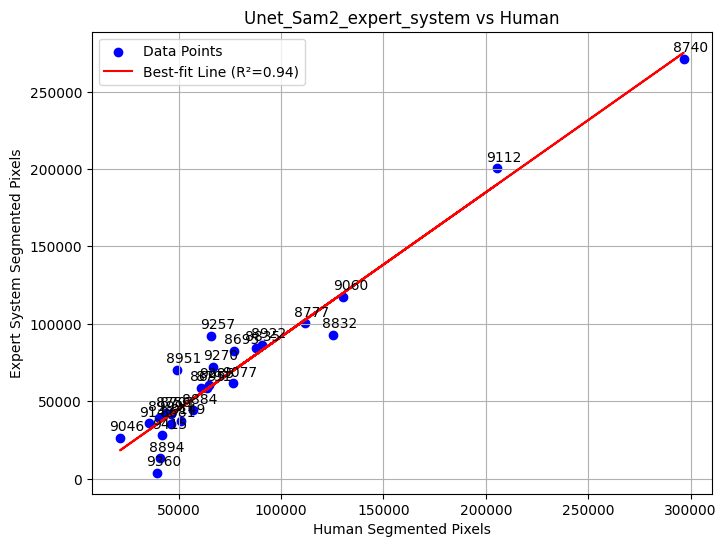

In [1]:
# Human vs Unet+Sam2 + expert system aneurysm
import os
import numpy as np
import torch
import random
import xlsxwriter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


class AneurysmDataset(Dataset):
    def __init__(self, file_paths, labels, input_size=200, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.input_size = input_size
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        segmented_pixels = self._load_segmented_pixels(file_path)
        patient_id = os.path.basename(os.path.dirname(file_path))
        start, end = self.labels.get(patient_id, (0, 0))  # Get labels for the patient ID
        
        # Ensure the input has a consistent size (200 frames)
        segmented_pixels = self._pad_or_truncate(segmented_pixels)
        
        return torch.tensor(segmented_pixels, dtype=torch.float32), patient_id, start, end
    
    def _load_segmented_pixels(self, file_path):
        segmented_pixels = {}
        with open(file_path, 'r') as f:
            for line in f:
                frame_info = line.split(':')[0].strip()
                pixel_value = int(line.split(':')[1].split('segmented pixels')[0].strip())
                frame_idx = int(frame_info.split(' ')[1])
                segmented_pixels[frame_idx] = pixel_value
        
        # Create a list of pixel values for each frame
        max_frame_idx = max(segmented_pixels.keys(), default=-1)
        pixel_values = [segmented_pixels.get(i, 0) for i in range(max_frame_idx + 1)]
        return pixel_values

    def _pad_or_truncate(self, data):
        if len(data) < self.input_size:
            data = data + [0] * (self.input_size - len(data))
        elif len(data) > self.input_size:
            data = data[:self.input_size]
        return data

# Function to get file paths and labels
def get_file_paths_and_labels(base_dir, label_file):
    file_paths = []
    labels = {}
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == 'segmented_pixels_per_slice.txt':
                file_path = os.path.join(root, file)
                patient_id = os.path.basename(os.path.dirname(file_path))
                file_paths.append(file_path)
    
    # Load labels
    with open(label_file, 'r') as f:
        for line in f:
            patient_id, start, end = line.strip().split(',')
            labels[patient_id] = (int(start), int(end))
    
    return file_paths, labels

# Function to find the abnormality with the highest sum of segmented pixels
def expert_system_find_highest_sum_abnormality(segmented_pixels_per_slice):
    abnormalities = []  # List to store all abnormality (start, end) pairs
    current_abnormality = None
    window_size = 3  # Window size for comparison
    
    for idx in range(window_size, len(segmented_pixels_per_slice)):
        prev_avg = np.mean(segmented_pixels_per_slice[idx - window_size:idx])
        
        # Check for a rise in segmented pixels
        if segmented_pixels_per_slice[idx] > prev_avg * 1.2:
            if all(segmented_pixels_per_slice[i] > prev_avg * 1.2 for i in range(idx, idx + window_size)):
                current_abnormality = {"start": idx}
        
        # Check for a drop in segmented pixels
        if current_abnormality is not None and "start" in current_abnormality:
            if segmented_pixels_per_slice[idx] < prev_avg * 0.8:
                if all(segmented_pixels_per_slice[i] < prev_avg * 0.8 for i in range(idx, idx + window_size)):
                    current_abnormality["end"] = idx
                    abnormalities.append(current_abnormality)  # Record the abnormality
                    current_abnormality = None  # Reset

    # Find the abnormality with the highest sum of segmented pixels
    highest_sum_abnormality = None
    highest_sum = 0
    
    for abnormality in abnormalities:
        if "start" in abnormality and "end" in abnormality:
            start, end = abnormality["start"], abnormality["end"]
            total_sum = sum(segmented_pixels_per_slice[start:end + 1])
            if total_sum > highest_sum:
                highest_sum = total_sum
                highest_sum_abnormality = abnormality

    # Return the start and end of the abnormality with the highest sum
    if highest_sum_abnormality:
        return highest_sum_abnormality["start"], highest_sum_abnormality["end"]
    else:
        return -1, -1

# Main processing function to collect pixel sums and plot the scatter plot
def process_patients_and_plot(file_paths, labels):
    expert_sums = []
    human_sums = []
    patient_ids = []
    
    dataset = AneurysmDataset(file_paths, labels, augment=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for data, patient_id, true_start, true_end in dataloader:
        data = data.squeeze().numpy()  # Convert to numpy for processing
        predicted_start, predicted_end = expert_system_find_highest_sum_abnormality(data)

        # Calculate sums for expert system
        expert_sum = sum(data[predicted_start:predicted_end + 1])

        # Calculate sums for human-determined regions
        human_sum = sum(data[true_start:true_end + 1])
        
        # print(predicted_start, predicted_end, data[predicted_start:predicted_end + 1], human_sum)
        

        expert_sums.append(expert_sum)
        human_sums.append(human_sum)
        patient_ids.append(patient_id[0][:4])  # Get the first 4 digits of the patient ID
    
    # Convert lists to numpy arrays for regression
    expert_sums_np = np.array(expert_sums).reshape(-1, 1)
    human_sums_np = np.array(human_sums).reshape(-1, 1)
    
    # Perform linear regression to get the best-fit line
    reg = LinearRegression()
    reg.fit(human_sums_np, expert_sums_np)
    y_pred = reg.predict(human_sums_np)
    
    # Calculate R-squared value
    r_sq = r2_score(expert_sums_np, y_pred)
    
    # Plot the scatter plot with the best-fit line and R-squared value
    plt.figure(figsize=(8, 6))
    plt.scatter(human_sums, expert_sums, color='blue', marker='o', label='Data Points')

    # Plot the best-fit line
    plt.plot(human_sums, y_pred, color='red', label=f'Best-fit Line (R²={r_sq:.2f})')

    # Annotate the plot with patient IDs
    for i, patient_id in enumerate(patient_ids):
        plt.annotate(patient_id, (human_sums[i], expert_sums[i]), textcoords="offset points", xytext=(5, 5), ha='center')

    # Add title and labels
    plt.title('Unet_Sam2_expert_system vs Human')
    plt.xlabel('Human Segmented Pixels')
    plt.ylabel('Expert System Segmented Pixels')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
base_dir = '/home/alireza/Desktop/aorta/sam2_pred_final'
label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/labels_70.txt'

# Assuming you have a function get_file_paths_and_labels to load data
file_paths, labels = get_file_paths_and_labels(base_dir, label_file)

# Process and plot the results
process_patients_and_plot(file_paths, labels)


## Human vs USL (loads from txt)

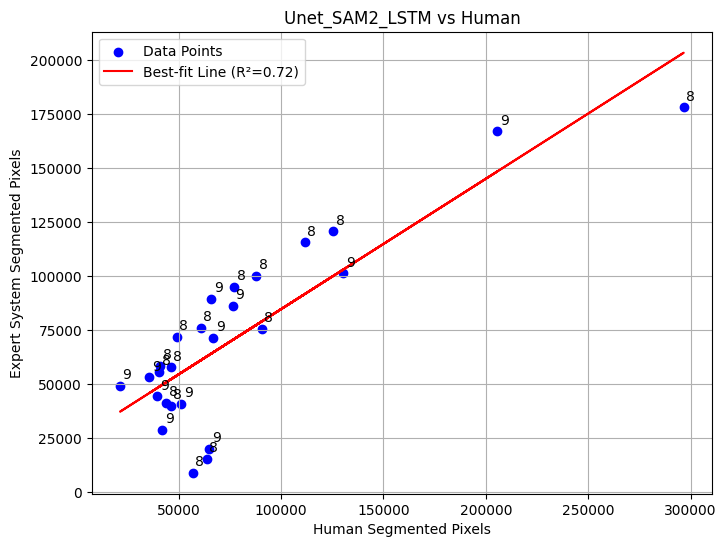

In [8]:
# Human vs Unet+Sam2 + LSTM aneurysm (loads from txt)
import os
import numpy as np
import torch
import random
import xlsxwriter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


class AneurysmDataset(Dataset):
    def __init__(self, file_paths, labels, input_size=200, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.input_size = input_size
        self.augment = augment

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        segmented_pixels = self._load_segmented_pixels(file_path)
        patient_id = os.path.basename(os.path.dirname(file_path))
        start, end = self.labels.get(patient_id, (0, 0))  # Get labels for the patient ID
        
        # Ensure the input has a consistent size (200 frames)
        segmented_pixels = self._pad_or_truncate(segmented_pixels)
        
        return torch.tensor(segmented_pixels, dtype=torch.float32), patient_id, start, end
    
    def _load_segmented_pixels(self, file_path):
        segmented_pixels = {}
        with open(file_path, 'r') as f:
            for line in f:
                frame_info = line.split(':')[0].strip()
                pixel_value = int(line.split(':')[1].split('segmented pixels')[0].strip())
                frame_idx = int(frame_info.split(' ')[1])
                segmented_pixels[frame_idx] = pixel_value
        
        # Create a list of pixel values for each frame
        max_frame_idx = max(segmented_pixels.keys(), default=-1)
        pixel_values = [segmented_pixels.get(i, 0) for i in range(max_frame_idx + 1)]
        return pixel_values

    def _pad_or_truncate(self, data):
        if len(data) < self.input_size:
            data = data + [0] * (self.input_size - len(data))
        elif len(data) > self.input_size:
            data = data[:self.input_size]
        return data

# Function to get file paths and labels
def get_file_paths_and_labels(base_dir, label_file):
    file_paths = []
    labels = {}
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == 'segmented_pixels_per_slice.txt':
                file_path = os.path.join(root, file)
                patient_id = os.path.basename(os.path.dirname(file_path))
                file_paths.append(file_path)
    
    # Load labels
    with open(label_file, 'r') as f:
        for line in f:
            patient_id, start, end = line.strip().split(',')
            labels[patient_id] = (int(start), int(end))
    
    return file_paths, labels


# Main processing function to collect pixel sums and plot the scatter plot
def process_patients_and_plot(file_paths, labels, label_target):
    expert_sums = []
    human_sums = []
    patient_ids = []
    
    dataset = AneurysmDataset(file_paths, labels, augment=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        
    dataset_target = AneurysmDataset(file_paths, label_target, augment=False)
    dataloader_target = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for (data, patient_id, true_start, true_end) in dataloader:
        patient_id = patient_id[0]  # Get the patient ID string
    # Access the corresponding predicted start and end values
        predicted_start, predicted_end = labels_target.get(patient_id, (0, 0))
        data = data.squeeze().numpy()  # Convert to numpy for processing

        # Calculate sums for expert system
        expert_sum = sum(data[predicted_start:predicted_end + 1])

        # Calculate sums for human-determined regions
        human_sum = sum(data[true_start:true_end + 1])
        
        # print(predicted_start, predicted_end,true_start, true_end )
        # print(predicted_start, predicted_end, data[predicted_start:predicted_end + 1], human_sum)
        

        expert_sums.append(expert_sum)
        human_sums.append(human_sum)
        patient_ids.append(patient_id[0][:4])  # Get the first 4 digits of the patient ID
    
    # Convert lists to numpy arrays for regression
    expert_sums_np = np.array(expert_sums).reshape(-1, 1)
    human_sums_np = np.array(human_sums).reshape(-1, 1)
    
    # Perform linear regression to get the best-fit line
    reg = LinearRegression()
    reg.fit(human_sums_np, expert_sums_np)
    y_pred = reg.predict(human_sums_np)
    
    # Calculate R-squared value
    r_sq = r2_score(expert_sums_np, y_pred)
    
    # Plot the scatter plot with the best-fit line and R-squared value
    plt.figure(figsize=(8, 6))
    plt.scatter(human_sums, expert_sums, color='blue', marker='o', label='Data Points')

    # Plot the best-fit line
    plt.plot(human_sums, y_pred, color='red', label=f'Best-fit Line (R²={r_sq:.2f})')

    # Annotate the plot with patient IDs
    for i, patient_id in enumerate(patient_ids):
        plt.annotate(patient_id, (human_sums[i], expert_sums[i]), textcoords="offset points", xytext=(5, 5), ha='center')

    # Add title and labels
    plt.title('Unet_SAM2_LSTM vs Human')
    plt.xlabel('Human Segmented Pixels')
    plt.ylabel('Expert System Segmented Pixels')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
base_dir = '/home/alireza/Desktop/aorta/sam2_pred'
label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/labels.txt'
label_target = '/home/alireza/Desktop/aorta/aneurysm_jpg/Unet_SAM2_LSTM.txt'

# Assuming you have a function get_file_paths_and_labels to load data
file_paths, labels = get_file_paths_and_labels(base_dir, label_file)
file_paths, labels_target = get_file_paths_and_labels(base_dir, label_target)


# Process and plot the results
process_patients_and_plot(file_paths, labels, labels_target)


## Plotting the predicted boundary for USE

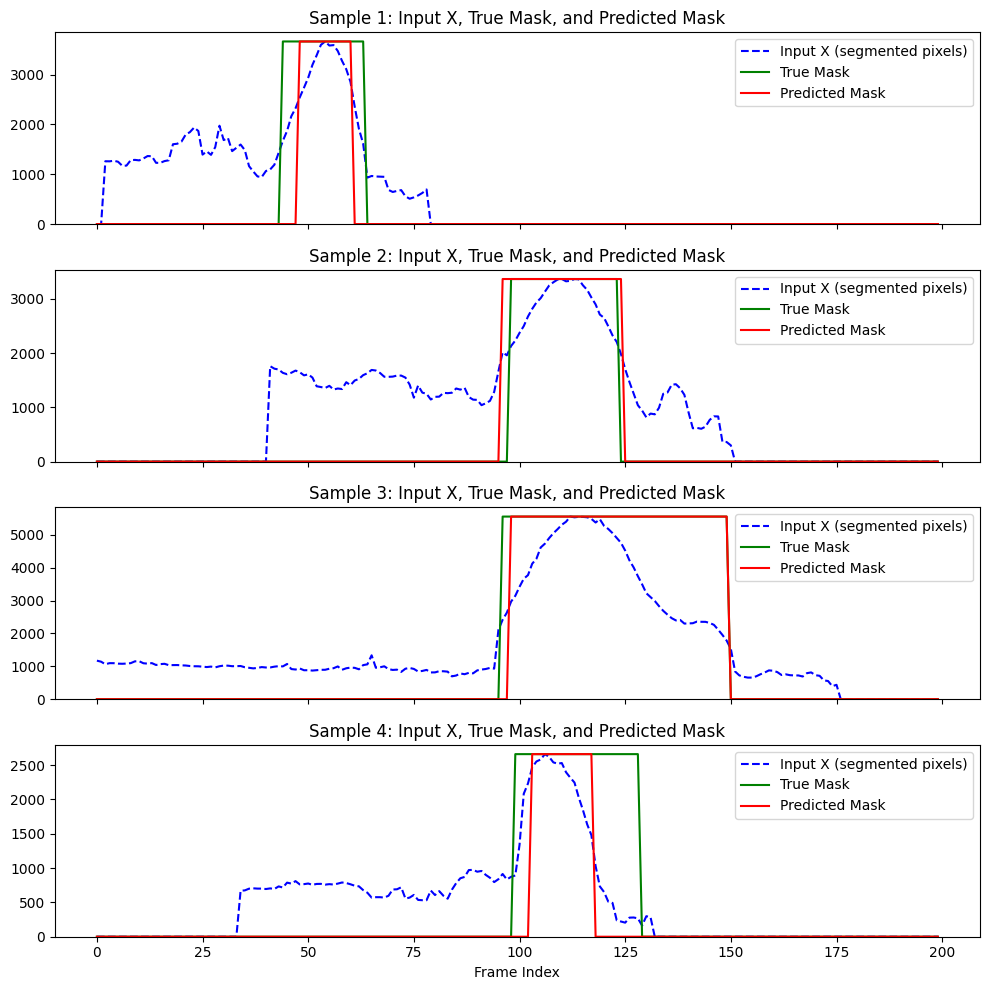

In [5]:
#Plotting the predicted boundary for Unet + SAM2 + Expert System
import os
import numpy as np
import matplotlib.pyplot as plt

# Define file paths and other constants
base_dir = '/home/alireza/Desktop/aorta/sam2_pred'
label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/labels.txt'
additional_label_file = '/home/alireza/Desktop/aorta/aneurysm_jpg/Unet_Sam2_expert_system.txt'
input_size = 200  # Define the number of frames

# Function to load segmented pixels from a file
def load_segmented_pixels(file_path):
    segmented_pixels = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame_info = line.split(':')[0].strip()
            pixel_value = int(line.split(':')[1].split('segmented pixels')[0].strip())
            frame_idx = int(frame_info.split(' ')[1])
            segmented_pixels[frame_idx] = pixel_value

    # Create a list of pixel values for each frame
    max_frame_idx = max(segmented_pixels.keys(), default=-1)
    pixel_values = [segmented_pixels.get(i, 0) for i in range(max_frame_idx + 1)]
    return pixel_values

# Function to load labels from a label file
def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            patient_id, start, end = line.strip().split(',')
            labels[patient_id] = (int(start), int(end))
    return labels

# Function to create a binary mask from start and end
def create_binary_mask(start, end, input_size=200):
    mask = np.zeros(input_size, dtype=np.int32)
    if start < input_size:
        mask[start:min(end, input_size)] = 1
    return mask

# Function to get file paths and labels
def get_file_paths_and_labels(base_dir, label_file, additional_label_file):
    file_paths = []
    labels = load_labels(label_file)
    additional_labels = load_labels(additional_label_file)  # Load additional labels
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == 'segmented_pixels_per_slice.txt':
                file_path = os.path.join(root, file)
                patient_id = os.path.basename(os.path.dirname(file_path))
                if patient_id in labels and patient_id in additional_labels:  # Ensure the file has both labels
                    file_paths.append((file_path, labels[patient_id], additional_labels[patient_id]))
    return file_paths

# Load data and labels
file_paths_and_labels = get_file_paths_and_labels(base_dir, label_file, additional_label_file)

# Function to plot segmented pixels and two binary masks
# Set up plotting style to match the uploaded image
def plot_multiple_patients_grid(file_paths_and_labels, input_size=200, max_samples=4):
    fig, axs = plt.subplots(max_samples, 1, figsize=(10, 10), sharex=True)

    for i, (file_path, (start1, end1), (start2, end2)) in enumerate(file_paths_and_labels[:max_samples]):
        segmented_pixels = load_segmented_pixels(file_path)
        
        # Adjust length
        if len(segmented_pixels) < input_size:
            segmented_pixels += [0] * (input_size - len(segmented_pixels))
        else:
            segmented_pixels = segmented_pixels[:input_size]

        mask1 = create_binary_mask(start1, end1, input_size)
        mask2 = create_binary_mask(start2, end2, input_size)

        ax = axs[i]
        ax.plot(segmented_pixels, 'b--', label='Input X (segmented pixels)')
        ax.plot(mask1 * max(segmented_pixels), 'g-', label='True Mask')
        ax.plot(mask2 * max(segmented_pixels), 'r-', label='Predicted Mask')
        ax.set_title(f"Sample {i+1}: Input X, True Mask, and Predicted Mask")
        ax.set_ylim(bottom=0)
        ax.legend(loc='upper right')

    plt.xlabel('Frame Index')
    plt.tight_layout()
    plt.show()
# Load and plot
file_paths_and_labels = get_file_paths_and_labels(base_dir, label_file, additional_label_file)
plot_multiple_patients_grid(file_paths_and_labels)
# Example usage: Load and plot data for each patient
for i, (file_path, (start1, end1), (start2, end2)) in enumerate(file_paths_and_labels):
    # Load segmented pixels
    segmented_pixels = load_segmented_pixels(file_path)
    
    # Pad or truncate segmented pixels to match input_size
    if len(segmented_pixels) < input_size:
        segmented_pixels = segmented_pixels + [0] * (input_size - len(segmented_pixels))
    elif len(segmented_pixels) > input_size:
        segmented_pixels = segmented_pixels[:input_size]

    # Create binary masks
    mask1 = create_binary_mask(start1, end1, input_size=input_size)  # Original mask
    mask2 = create_binary_mask(start2, end2, input_size=input_size)  # Additional mask from second label file
    
    # Plot segmented pixels and binary masks
    # plot_segmented_pixels_and_masks(segmented_pixels, mask1, mask2, title=f"Patient {i+1}")
    
    if i >= 2:  # Plot for only the first 5 patients
        break
